Installation & Imports

In [13]:
!pip install fairlearn seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

Load & Preprocess Dataset

In [17]:
# Load dataset
data = pd.read_csv("/content/adult.data", header=None, na_values=' ?')
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
print(data.columns.values)

# Select relevant columns
data = data[['age', 'education.num', 'hours.per.week', 'sex', 'income']]

# One-hot encode (drop first to avoid dummy trap)
data = pd.get_dummies(data, drop_first=True)

print(data.columns.values)

# Prepare X and y
X = data.drop('income_ >50K', axis=1)
y = data['income_ >50K']

['age' 'workclass' 'fnlwgt' 'education' 'education.num' 'marital.status'
 'occupation' 'relationship' 'race' 'sex' 'capital.gain' 'capital.loss'
 'hours.per.week' 'native.country' 'income']
['age' 'education.num' 'hours.per.week' 'sex_ Male' 'income_ >50K']


Training & Evaluation of Baseline Model

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(y_pred)

# Fairness evaluation
sex = X_test['sex_ Male']
metric_frame = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sex
)

print("Selection Rates by Gender:\n", metric_frame.by_group)

[False False False ... False False  True]
Selection Rates by Gender:
 sex_ Male
False    0.018221
True     0.199816
Name: selection_rate, dtype: float64


Visualization of Selection Rates

/tmp/ipython-input-2449508845.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Female': metric_frame.by_group[0],
/tmp/ipython-input-2449508845.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Male': metric_frame.by_group[1]


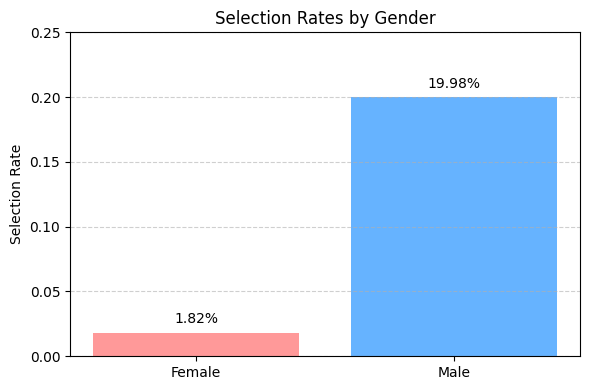

In [20]:
# Example selection rates from MetricFrame (replace with your metric_frame.by_group values)
selection_rates = {
    'Female': metric_frame.by_group[0],
    'Male': metric_frame.by_group[1]
}

# Convert to DataFrame
df = pd.DataFrame(list(selection_rates.items()), columns=["Gender", "Selection Rate"])

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(df["Gender"], df["Selection Rate"], color=["#ff9999", "#66b3ff"])
plt.title("Selection Rates by Gender")
plt.ylabel("Selection Rate")
plt.ylim(0, 0.25)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Fair Model with Demographic Parity

In [22]:
# Sensitive feature for fairness constraints
sensitive_feature = X['sex_ Male']

# Split with sensitive feature
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

# Base estimator
estimator = LogisticRegression(max_iter=1000)

# Apply fairness constraint: Demographic Parity
fair_model = ExponentiatedGradient(
    estimator,
    constraints=DemographicParity(),
    eps=0.01  # fairness tolerance
)

# Train
fair_model.fit(X_train, y_train, sensitive_features=sf_train)

# Predict
y_pred_fair = fair_model.predict(X_test)

# Evaluate fairness + accuracy
metric_frame_fair = MetricFrame(
    metrics={
        "Selection Rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sf_test
)

print(metric_frame_fair.by_group)

           Selection Rate  Accuracy
sex_ Male                          
False            0.106238  0.857319
True             0.114071  0.744143
